# Air Pollution Forecasting

## Load Data

In [40]:
from google.colab import files

In [41]:
!kaggle datasets download -d rupakroy/lstm-datasets-multivariate-univariate --unzip -p LSTM-Multivariate_pollution

Dataset URL: https://www.kaggle.com/datasets/rupakroy/lstm-datasets-multivariate-univariate
License(s): DbCL-1.0
100% 444k/444k [00:00<00:00, 1.12MB/s]
100% 444k/444k [00:00<00:00, 1.12MB/s]


## Library

In [42]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense, BatchNormalization, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Exploratory Data Analysis

In [43]:
df_train = pd.read_csv('/content/LSTM-Multivariate_pollution/LSTM-Multivariate_pollution.csv')
df_train

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [44]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  43800 non-null  float64
 2   dew        43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non-null  int64  
 8   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.0+ MB


In [45]:
df_test = pd.read_csv("/content/LSTM-Multivariate_pollution/pollution_test_data1.csv")
df_test

,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution
0,-16,4,1027,SE,3.58,0,0,128
1,-17,5,1027,SE,7.60,0,0,77
2,-16,4,1027,SE,9.39,0,0,65
3,-16,1,1028,cv,0.89,0,0,79
4,-14,0,1028,NE,1.79,0,0,93
...,...,...,...,...,...,...,...,...
341,-23,-2,1034,NW,231.97,0,0,8
342,-22,-3,1034,NW,237.78,0,0,10
343,-22,-3,1034,NW,242.70,0,0,10
344,-22,-4,1034,NW,246.72,0,0,8


In [46]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dew        346 non-null    int64  
 1   temp       346 non-null    int64  
 2   press      346 non-null    int64  
 3   wnd_dir    346 non-null    object 
 4   wnd_spd    346 non-null    float64
 5   snow       346 non-null    int64  
 6   rain       346 non-null    int64  
 7   pollution  346 non-null    int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 21.8+ KB


In [47]:
print("train data\n", df_train.isnull().sum())

train data
 date         0
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64


In [48]:
print("test data\n", df_test.isnull().sum())

test data
 dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
pollution    0
dtype: int64


In [49]:
df_train.shape

(43800, 9)

In [50]:
df_train.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


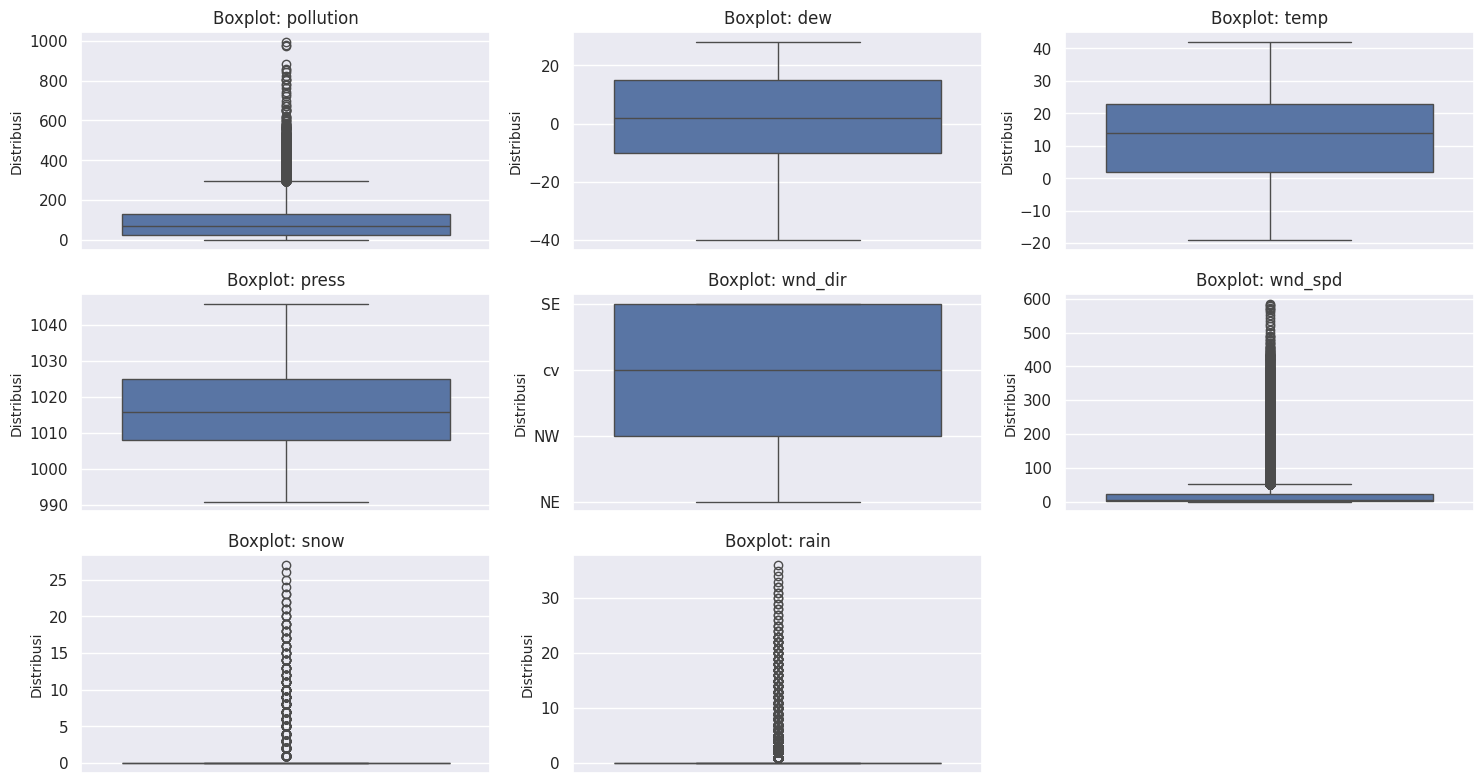

In [51]:
columns_to_plot = [col for col in df_train.columns if col != 'date']

rows = 3
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    sns.boxplot(y=df_train[col], ax=axes[i])
    axes[i].set_title(f"Boxplot: {col}", fontsize=12)
    axes[i].set_ylabel("Distribusi", fontsize=10)
    axes[i].set_xlabel("")

for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

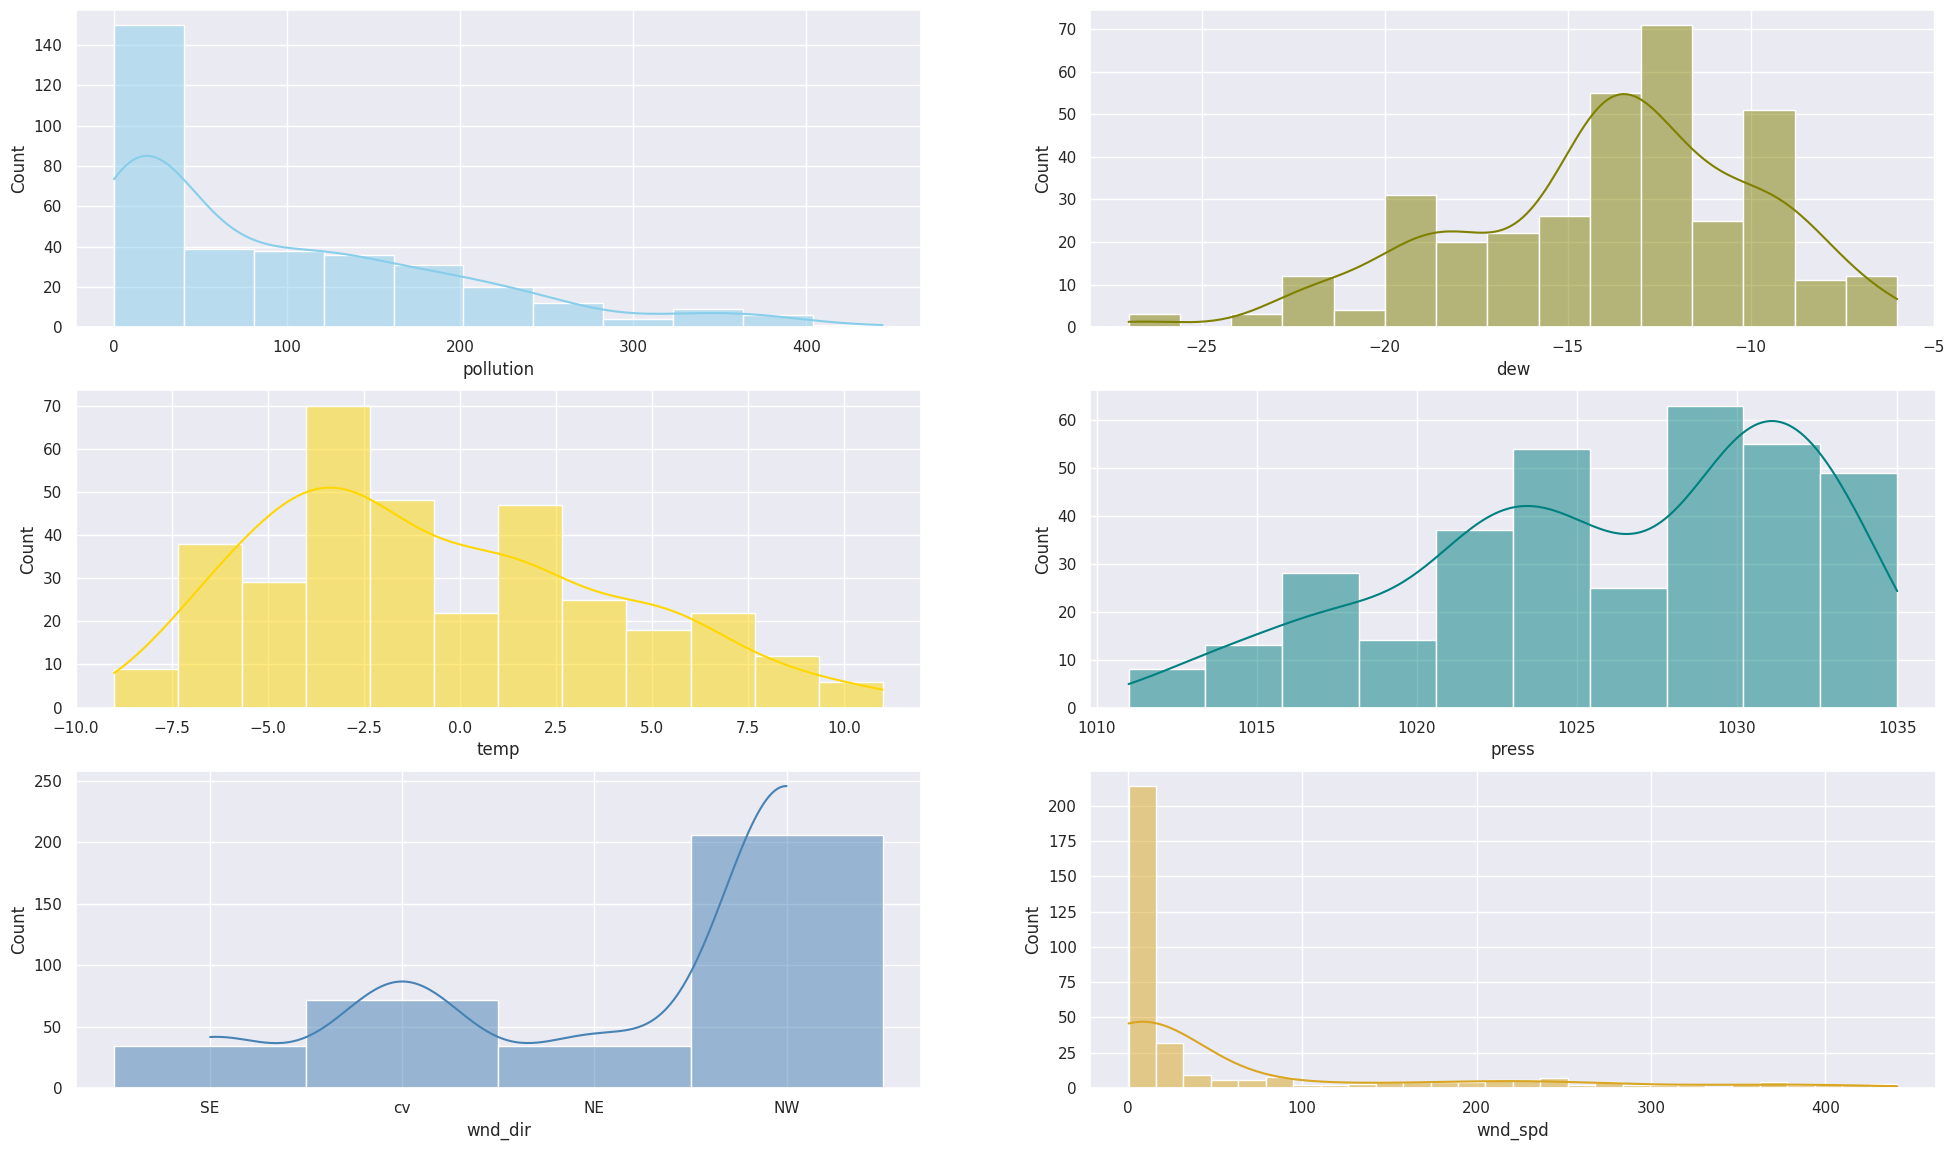

In [52]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(3,2, figsize=(24,14))

sns.histplot(data=df_test, x="pollution", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df_test, x="dew", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df_test, x="temp", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=df_test, x="press", kde=True, color="teal", ax=axs[1, 1])
sns.histplot(data=df_test, x="wnd_dir", kde=True, color="steelblue", ax=axs[2, 0])
sns.histplot(data=df_test, x="wnd_spd", kde=True, color="goldenrod", ax=axs[2, 1])

plt.show()

## Data Preparation

In [53]:
mapping = {'NE': 0, 'SE': 1, 'NW': 2, 'cv': 3}

df_train['wnd_dir'] = df_train['wnd_dir'].map(mapping)
df_test['wnd_dir'] = df_test['wnd_dir'].map(mapping)

df_train['date'] = pd.to_datetime(df_train['date'])

df_train.set_index('date', inplace=True)
df_train.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,1,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,1,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,1,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,1,6.25,2,0


In [54]:
scaler = MinMaxScaler()

columns = (['pollution', 'dew', 'temp', 'press', "wnd_dir", 'wnd_spd',
       'snow', 'rain'])

df_test = df_test[columns]

df_train[columns] = scaler.fit_transform(df_train[columns])
df_test[columns] = scaler.transform(df_test[columns])

df_train.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,0.129779,0.352941,0.245902,0.527273,0.333333,0.002290,0.000000,0.0
2010-01-02 01:00:00,0.148893,0.367647,0.245902,0.527273,0.333333,0.003811,0.000000,0.0
2010-01-02 02:00:00,0.159960,0.426471,0.229508,0.545455,0.333333,0.005332,0.000000,0.0
2010-01-02 03:00:00,0.182093,0.485294,0.229508,0.563636,0.333333,0.008391,0.037037,0.0
2010-01-02 04:00:00,0.138833,0.485294,0.229508,0.563636,0.333333,0.009912,0.074074,0.0


In [55]:
df_test.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,0.128773,0.352941,0.377049,0.654545,0.333333,0.005349,0.0,0.0
1,0.077465,0.338235,0.393443,0.654545,0.333333,0.012219,0.0,0.0
2,0.065392,0.352941,0.377049,0.654545,0.333333,0.015278,0.0,0.0
3,0.079477,0.352941,0.327869,0.672727,1.000000,0.000752,0.0,0.0
4,0.093561,0.382353,0.311475,0.672727,0.000000,0.002290,0.0,0.0


In [56]:
df_train_scaled = np.array(df_train)
df_test_scaled = np.array(df_test)

X = []
y = []
n_future = 1
n_past = 11

for i in range(n_past, len(df_train_scaled) - n_future+1):
    X.append(df_train_scaled[i - n_past:i, 1:df_train_scaled.shape[1]])
    y.append(df_train_scaled[i + n_future - 1:i + n_future, 0])
X_train, y_train = np.array(X), np.array(y)

X = []
y = []
for i in range(n_past, len(df_test_scaled) - n_future+1):
    X.append(df_test_scaled[i - n_past:i, 1:df_test_scaled.shape[1]])
    y.append(df_test_scaled[i + n_future - 1:i + n_future, 0])
X_test, y_test = np.array(X), np.array(y)

print('train shape : {}, {} \n'
      'test shape : {}, {} '.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

train shape : (43789, 11, 7), (43789, 1) 
test shape : (335, 11, 7), (335, 1) 


## LSTM Model

In [57]:
model = Sequential()

# Lapisan LSTM pertama
model.add(LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True,
))
model.add(Dropout(0.3))

# Lapisan LSTM kedua
model.add(LSTM(
    units=32,
    return_sequences=True
))
model.add(Dropout(0.3))

# Lapisan LSTM ketiga
model.add(LSTM(
    units=16,
    return_sequences=False
))
model.add(Dropout(0.3))

# Lapisan Dense untuk output
model.add(Dense(y_train.shape[1]))

# Compile model
model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.001),
    metrics=[RootMeanSquaredError()]
)

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 11, 64)              │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 11, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 11, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,001 (132.82 KB)

 Trainable params: 34,001 (132.82 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [59]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=[early_stopping, checkpoint], shuffle=False)

Epoch 1/30
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - loss: 0.0090 - root_mean_squared_error: 0.0946 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1063
Epoch 2/30
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - loss: 0.0076 - root_mean_squared_error: 0.0870 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1038
Epoch 3/30
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 0.0071 - root_mean_squared_error: 0.0842 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1030
Epoch 4/30
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - loss: 0.0068 - root_mean_squared_error: 0.0826 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0991
Epoch 5/30
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - loss: 0.0066 - root_mean_squared_error: 0.0811 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0992
Epoch 6/30
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0066 - root_mean_squared_error: 0.0810 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0966
Epoch 7/30
1232/1232 ━━━━━━━

In [60]:
best_model = load_model('best_model.keras')

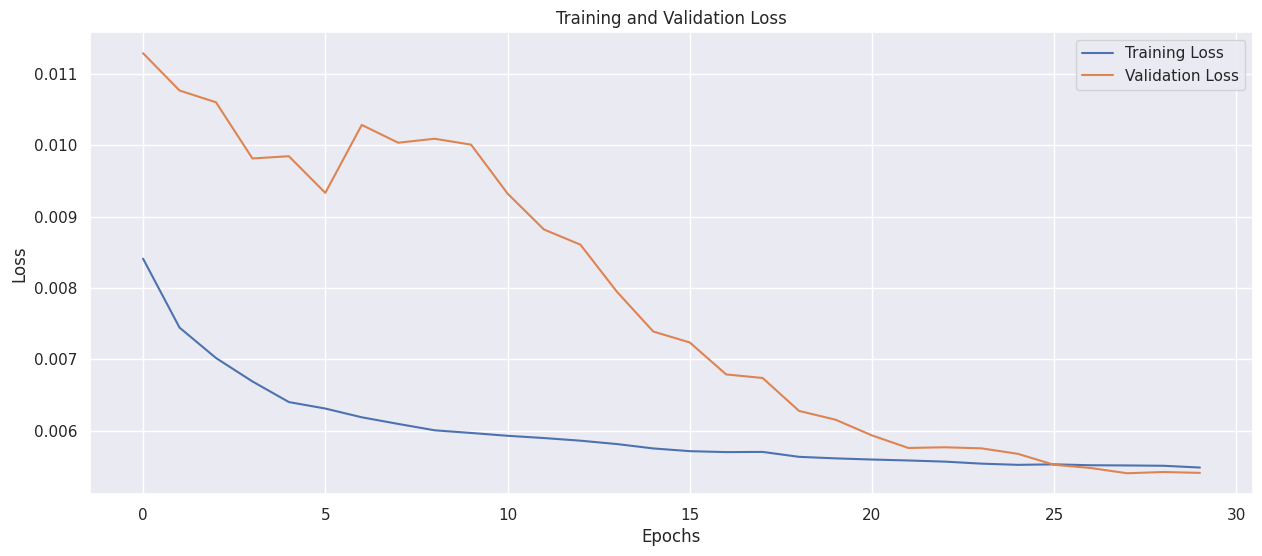

In [61]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
test_predictions = best_model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test.flatten()})
test_results.head()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


,Train Predictions,Actual
0,0.068067,0.171026
1,0.074342,0.160966
2,0.081657,0.146881
3,0.093322,0.125755
4,0.087723,0.130785


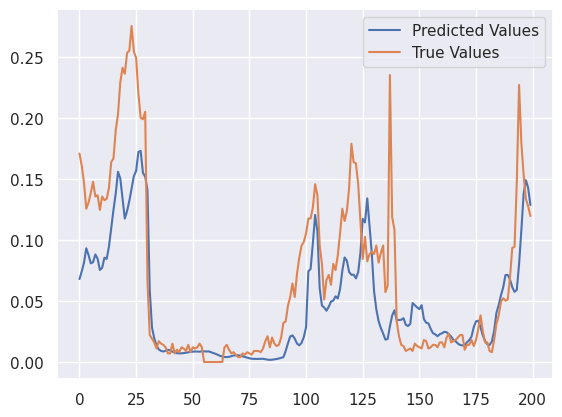

In [63]:
plt.plot(test_results['Train Predictions'][:200], label='Predicted Values')
plt.plot(test_results['Actual'][:200], label='True Values')
plt.legend()
plt.show()

## GRU Model

In [25]:
model = Sequential()

# Lapisan GRU pertama
model.add(GRU(
    units=128,
    input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True,
    kernel_regularizer='l2',
))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Lapisan GRU kedua
model.add(GRU(
    units=64,
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Lapisan GRU ketiga
model.add(GRU(
    units=32,
    return_sequences=False
))
model.add(Dropout(0.3))

# Lapisan Dense tambahan
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.001),
    metrics=[RootMeanSquaredError()]
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 11, 128)             │          52,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 11, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 11, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 11, 64)              │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 11, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,209 (399.25 KB)

 Trainable params: 101,825 (397.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [26]:
# Callback untuk menyimpan model terbaik
gru_model_checkpoint = ModelCheckpoint('best_gru_model.keras', monitor='val_loss', save_best_only=True)

In [27]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=[early_stopping, gru_model_checkpoint], shuffle=False)

Epoch 1/30
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 51s 36ms/step - loss: 0.0636 - root_mean_squared_error: 0.1703 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0932
Epoch 2/30
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - loss: 0.0087 - root_mean_squared_error: 0.0925 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896
Epoch 3/30
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - loss: 0.0084 - root_mean_squared_error: 0.0916 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0897
Epoch 4/30
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - loss: 0.0084 - root_mean_squared_error: 0.0914 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0897
Epoch 5/30
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - loss: 0.0084 - root_mean_squared_error: 0.0914 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0897
Epoch 6/30
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - loss: 0.0084 - root_mean_squared_error: 0.0915 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0897
Epoch 7/30
1232/1232 ━━━━━━━

In [28]:
best_gru_model = load_model('best_gru_model.keras')

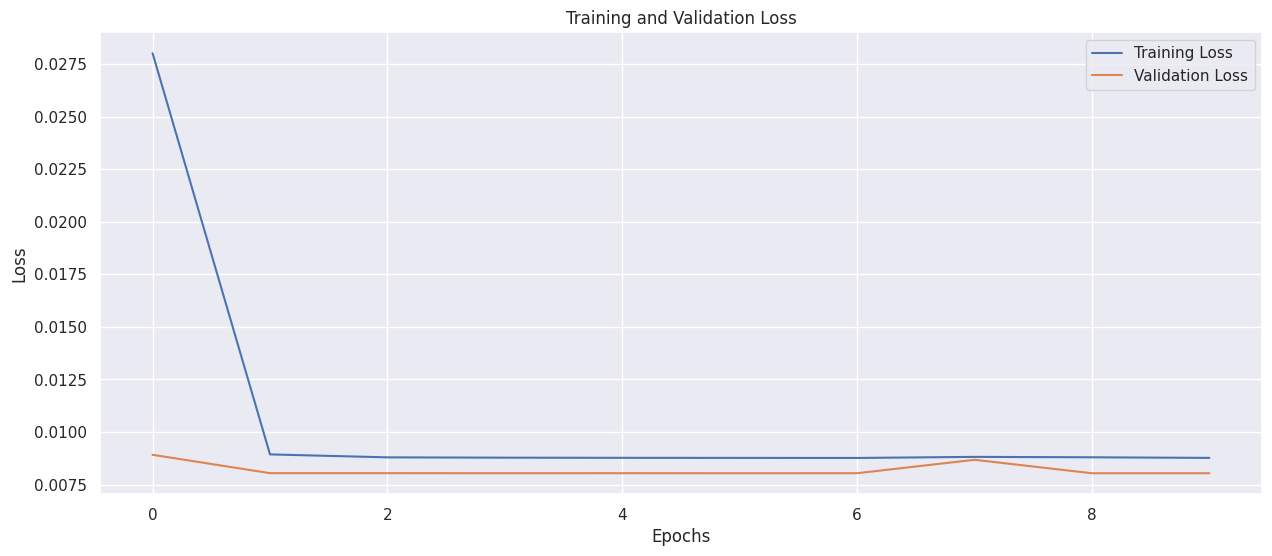

In [29]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
test_predictions_gru = best_gru_model.predict(X_test).flatten()
test_results_gru = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test.flatten()})
test_results_gru.head()

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step


,Train Predictions,Actual
0,0.062803,0.171026
1,0.068999,0.160966
2,0.081108,0.146881
3,0.100686,0.125755
4,0.090592,0.130785


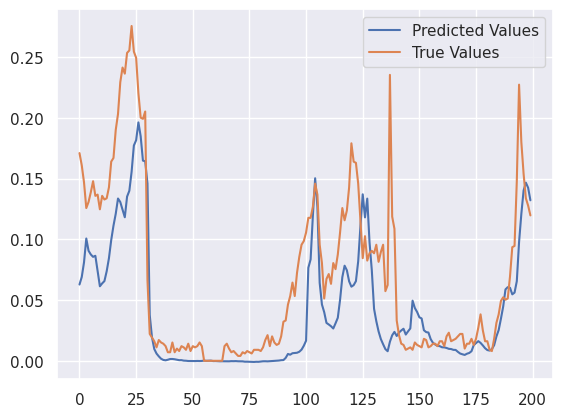

In [34]:
plt.plot(test_results_gru['Train Predictions'][:200], label='Predicted Values')
plt.plot(test_results_gru['Actual'][:200], label='True Values')
plt.legend()
plt.show()

## Evaluasi

In [32]:
gru_train_mse = best_gru_model.evaluate(X_train, y_train, verbose=0)[0]
gru_test_mse = best_gru_model.evaluate(X_test, y_test, verbose=0)[0]

print(f"GRU Train MSE: {gru_train_mse}")
print(f"GRU Test MSE: {gru_test_mse}")

lstm_train_mse = best_model.evaluate(X_train, y_train, verbose=0)[0]
lstm_test_mse = best_model.evaluate(X_test, y_test, verbose=0)[0]

print(f"LSTM Train MSE: {lstm_train_mse}")
print(f"LSTM Test MSE: {lstm_test_mse}")

GRU Train MSE: 0.008618607185781002
GRU Test MSE: 0.009875888004899025
LSTM Train MSE: 0.006941657979041338
LSTM Test MSE: 0.00755618792027235


In [33]:
gru_train_rmse = best_gru_model.evaluate(X_train, y_train, verbose=0)[1]
gru_test_rmse = best_gru_model.evaluate(X_test, y_test, verbose=0)[1]

print(f"GRU Train RMSE: {gru_train_rmse}")
print(f"GRU Test RMSE: {gru_test_rmse}")

lstm_train_rmse = best_model.evaluate(X_train, y_train, verbose=0)[1]
lstm_test_rmse = best_model.evaluate(X_test, y_test, verbose=0)[1]

print(f"LSTM Train RMSE: {lstm_train_rmse}")
print(f"LSTM Test RMSE: {lstm_test_rmse}")

GRU Train RMSE: 0.09283643215894699
GRU Test RMSE: 0.09937747567892075
LSTM Train RMSE: 0.0833166092634201
LSTM Test RMSE: 0.08692633360624313
